In [41]:
import pandas as pd
import plotly.express as px
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score



In [42]:
# pdf_mvp = pd.read_csv('data/intermediate/model_data_prep.csv')

In [43]:
# pdf_mvp

In [44]:
pdf_valuations = pd.read_csv('data/input/player_valuations.csv')[["player_id", "date", "market_value_in_eur"]]
pdf_players = pd.read_csv('data/input/players.csv')[["player_id", "name", "date_of_birth", "position", "sub_position", "contract_expiration_date", "current_club_name", "current_club_domestic_competition_id" ]]

In [45]:
pdf_joined = pdf_players.merge(pdf_valuations, on="player_id").query("current_club_domestic_competition_id == 'GB1'")
pdf_joined["age"] = (pd.to_datetime(pdf_joined["date"]) - pd.to_datetime(pdf_joined["date_of_birth"])).dt.days // 365
pdf_joined["year"] = pd.to_datetime(pdf_joined["date"]).dt.year
pdf_joined["month"] = pd.to_datetime(pdf_joined["date"]).dt.month

pdf_joined["market_value_in_million_eur"] = pdf_joined["market_value_in_eur"] / 1000000

In [46]:
pdf_mvp = pdf_joined[["name", "player_id", "date_of_birth", "date", "market_value_in_million_eur", "age", "year", "month" ]]

In [47]:
# Filter training and test sets
train = pdf_mvp[pdf_mvp["year"] <= 2022].sort_values("date", ascending=False)
test = pdf_mvp[(pdf_mvp["year"] >= 2023)].sort_values("date", ascending=False)

In [48]:
pdf_train_agg= train.query("year == 2022").groupby(["player_id", "name"])[["date_of_birth", "market_value_in_million_eur", "age"]].first().reset_index()

In [49]:
pdf_test_agg = test.query("year == 2023").groupby(["player_id", "name"])[["date_of_birth", "market_value_in_million_eur", "age"]].last().reset_index()

In [50]:
pdf_test_train = pdf_train_agg.merge(pdf_test_agg, on=["player_id", "name"], suffixes=("_train", "_test"))

In [51]:
pdf_test_train

,player_id,name,date_of_birth_train,market_value_in_million_eur_train,age_train,date_of_birth_test,market_value_in_million_eur_test,age_test
0,2857,Eldin Jakupovic,1984-10-02 00:00:00,0.20,38,1984-10-02 00:00:00,0.100,38
1,3333,James Milner,1986-01-04 00:00:00,2.00,36,1986-01-04 00:00:00,1.500,37
2,3755,Óscar Ustari,1986-07-03 00:00:00,1.00,36,1986-07-03 00:00:00,1.000,36
3,6893,Gabriel Tamas,1983-11-09 00:00:00,0.25,38,1983-11-09 00:00:00,0.100,39
4,8198,Cristiano Ronaldo,1985-02-05 00:00:00,20.00,37,1985-02-05 00:00:00,15.000,38
...,...,...,...,...,...,...,...,...
1231,996897,Diego Gómez,2003-03-27 00:00:00,2.00,19,2003-03-27 00:00:00,3.000,20
1232,1009658,Julio Soler,2005-02-16 00:00:00,0.20,17,2005-02-16 00:00:00,0.200,18
1233,1012534,Yankuba Minteh,2004-07-22 00:00:00,0.30,18,2004-07-22 00:00:00,2.000,18
1234,1031293,Ryan Oné,2006-06-26 00:00:00,0.05,16,2006-06-26 00:00:00,0.125,16


In [52]:


# Prepare features and target, now including market_value_in_eur as a feature



features = [
            "age_train", 
            "market_value_in_million_eur_train"]
target = "market_value_in_million_eur_test"

X = pdf_test_train[features]
y = pdf_test_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit Decision Tree on current age and value
regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse:.4f}")

r2 = r2_score(y_test, y_pred)
print(f"R² = {r2:.3f}")

Root Mean Squared Error: 3.8957
R² = 0.934


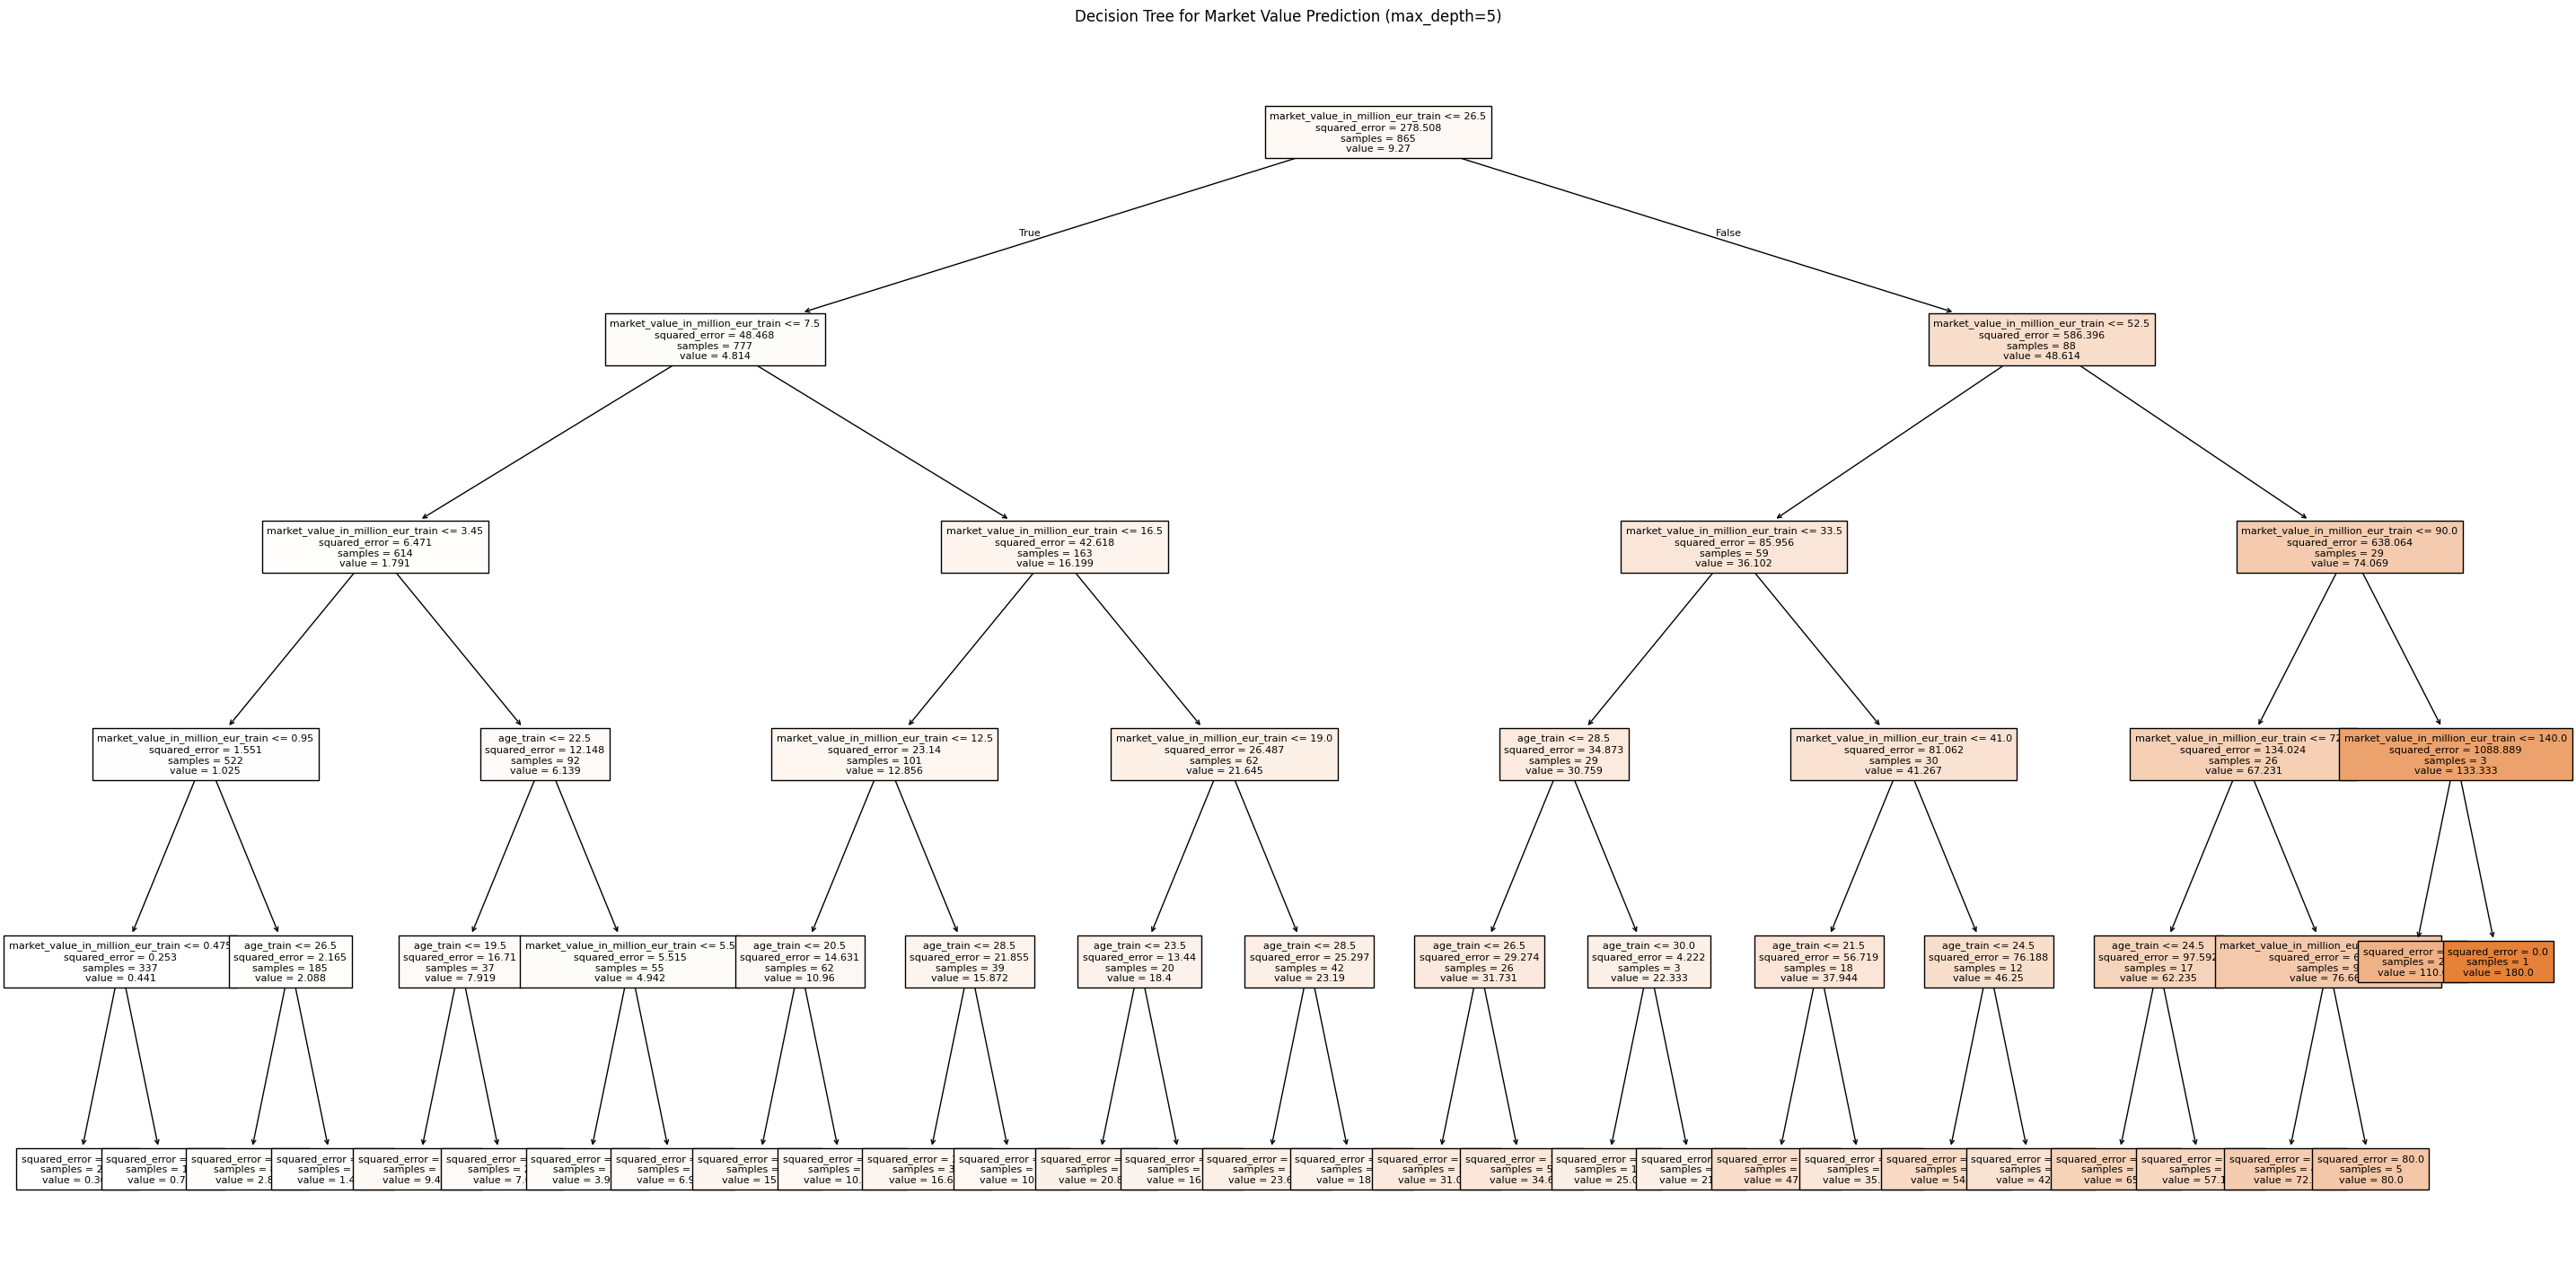

In [53]:


plt.figure(figsize=(36, 18))
tree.plot_tree(regressor, feature_names=features, filled=True, fontsize=8)
plt.title("Decision Tree for Market Value Prediction (max_depth=5)")
plt.show()

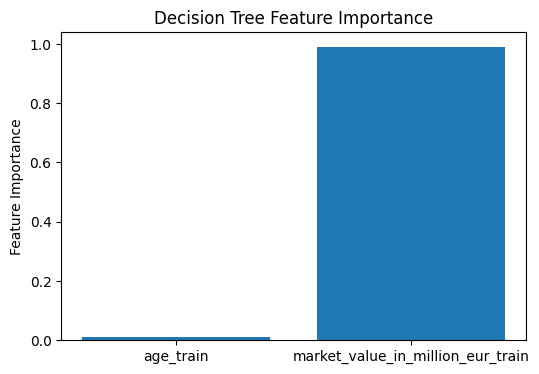

In [54]:
# Plot feature importance for the decision tree
feature_names = features
importances = regressor.feature_importances_

plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances)
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

In [55]:
X_test["market_value_in_eur_test"] = y_test
X_test["prediction"] = y_pred

In [56]:
pdf_output = X_test.merge(pdf_test_train[["player_id", "name"]], left_index=True, right_index=True, how="left")

In [57]:
px.scatter(pdf_output, x="market_value_in_eur_test", y="prediction", title="Market Value Prediction vs Actual Values", hover_data=["name"])